<a href="https://colab.research.google.com/github/aneesha17/dinov2/blob/main/human_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training segmentation model with linear classifier on human_parsing_dataset

---



Installing libraries

In [ ]:
!pip install torch torchvision


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.2 MB/s eta 0:00:00


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.4 MB/s eta 0:00:00


In [ ]:
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

dataset = load_dataset("mattmdjaga/human_parsing_dataset",split="train[:2000]")

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)
# train_ds = dataset["train"]
# test_ds = dataset["test"]

In [ ]:
from torch.utils.data import Dataset
import torch

class SegmentationDataset(Dataset):
  def __init__(self, dataset, transform):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    original_image = np.array(item["image"])
    original_segmentation_map = np.array(item["mask"])

    transformed = self.transform(image=original_image, mask=original_segmentation_map)
    image, target = torch.tensor(transformed['image']), torch.LongTensor(transformed['mask'])

    # convert to C, H, W
    image = image.permute(2,0,1)

    return image, target, original_image, original_segmentation_map

In [ ]:
import numpy as np

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['image', 'mask'],
        num_rows: 400
    })
})

In [ ]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    A.Resize(width=448, height=448),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

val_transform = A.Compose([
    A.Resize(width=448, height=448),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),

])

train_dataset = SegmentationDataset(dataset["train"], transform=train_transform)
val_dataset = SegmentationDataset(dataset["test"], transform=val_transform)

In [ ]:
pixel_values, target, original_image, original_segmentation_map = train_dataset[3]


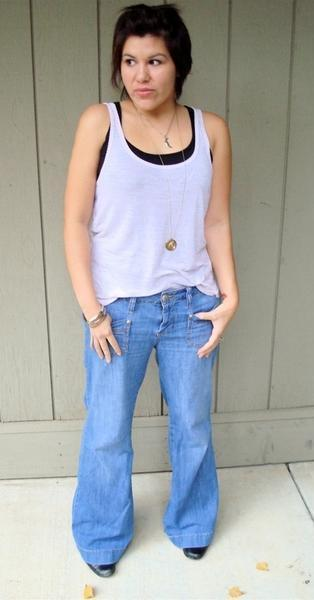

In [ ]:
from PIL import Image

Image.fromarray(original_image)

In [ ]:
categories={
    0: "Background", 1: "Hat", 2: "Hair", 3: "Sunglasses", 4: "Upper-clothes", 5: "Skirt", 6: "Pants", 7: "Dress", 8: "Belt", 9: "Left-shoe", 10: "Right-shoe", 11: "Face", 12: "Left-leg", 13: "Right-leg", 14: "Left-arm",15: "Right-arm", 16: "Bag", 17: "Scarf"
}

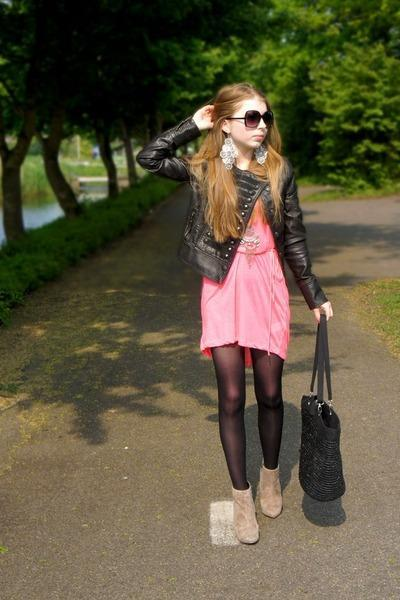

In [ ]:
example = dataset["train"][0]
image = example["image"]
image

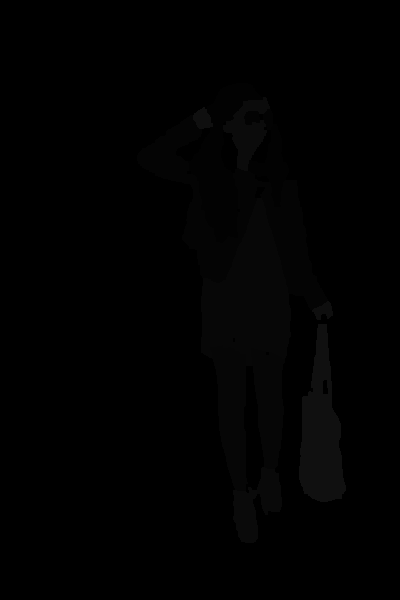

In [ ]:
segmentation_map = example["mask"]
segmentation_map

In [ ]:
import numpy as np

segmentation_map = np.array(segmentation_map)
segmentation_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

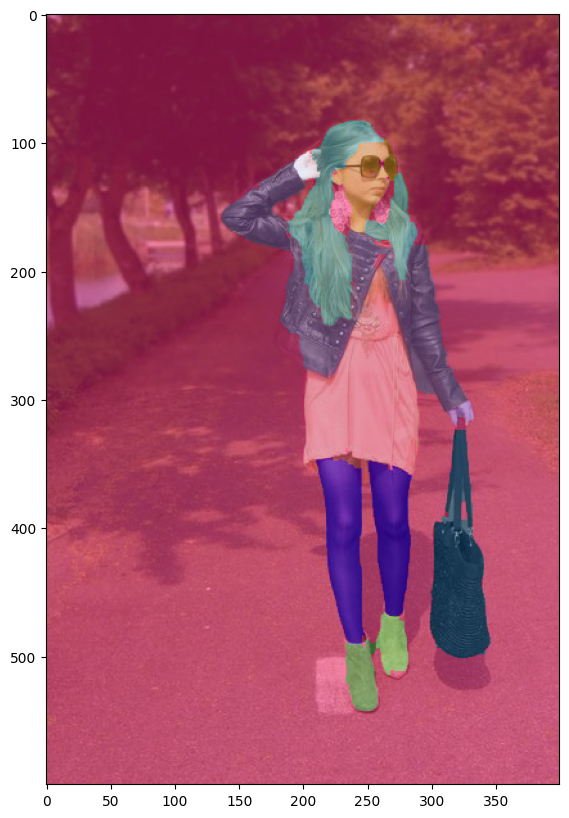

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# map every class to a random color
id2color = {k: list(np.random.choice(range(256), size=3)) for k,v in categories.items()}

def visualize_map(image, segmentation_map):
    color_seg = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
    for label, color in id2color.items():
        color_seg[segmentation_map == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()

visualize_map(image, segmentation_map)

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(inputs):
    batch = dict()
    batch["pixel_values"] = torch.stack([i[0] for i in inputs], dim=0)
    batch["labels"] = torch.stack([i[1] for i in inputs], dim=0)
    batch["original_images"] = [i[2] for i in inputs]
    batch["original_segmentation_maps"] = [i[3] for i in inputs]

    return batch

train_dataloader = DataLoader(train_dataset, batch_size=30, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=30, shuffle=False, collate_fn=collate_fn)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v,torch.Tensor):
    print(k,v.shape)

pixel_values torch.Size([30, 3, 448, 448])
labels torch.Size([30, 448, 448])


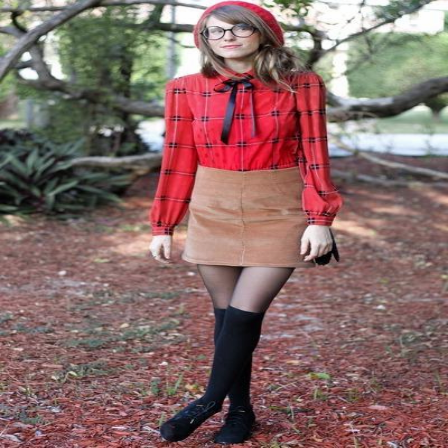

In [ ]:
from PIL import Image

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = Image.fromarray(unnormalized_image)
unnormalized_image

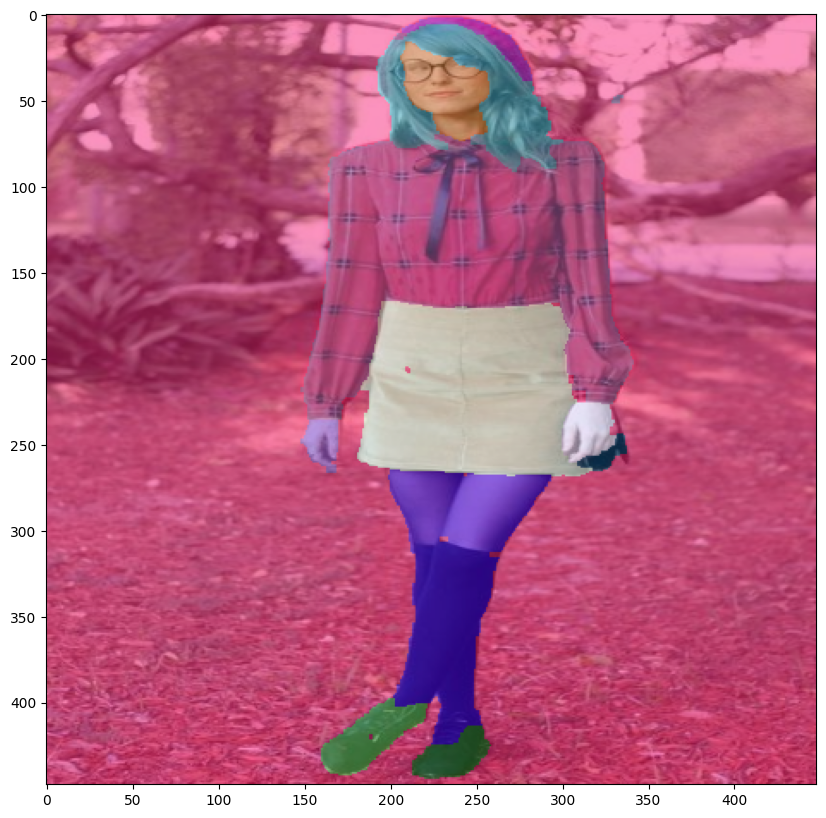

In [ ]:
visualize_map(unnormalized_image, batch["labels"][0].numpy())

In [ ]:
import torch
from transformers import Dinov2Model, Dinov2PreTrainedModel
from transformers.modeling_outputs import SemanticSegmenterOutput

class LinearClassifier(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearClassifier, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.classifier = torch.nn.Conv2d(in_channels, num_labels, (1,1))

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.classifier(embeddings)


class Dinov2ForSemanticSegmentation(Dinov2PreTrainedModel):
  def __init__(self, config):
    super().__init__(config)

    self.dinov2 = Dinov2Model(config)
    self.classifier = LinearClassifier(config.hidden_size, 32, 32, config.num_labels)

  def forward(self, pixel_values, output_hidden_states=False, output_attentions=False, labels=None):
    # use frozen features
    outputs = self.dinov2(pixel_values,
                            output_hidden_states=output_hidden_states,
                            output_attentions=output_attentions)
    # get the patch embeddings - so we exclude the CLS token
    patch_embeddings = outputs.last_hidden_state[:,1:,:]

    # convert to logits and upsample to the size of the pixel values
    logits = self.classifier(patch_embeddings)
    logits = torch.nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)

    loss = None
    if labels is not None:
      # important: we're going to use 0 here as ignore index instead of the default -100
      # as we don't want the model to learn to predict background
      loss_fct = torch.nn.CrossEntropyLoss(ignore_index=0)
      loss = loss_fct(logits.squeeze(), labels.squeeze())

    return SemanticSegmenterOutput(
        loss=loss,
        logits=logits,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions,
    )

In [ ]:
model = Dinov2ForSemanticSegmentation.from_pretrained("facebook/dinov2-base", id2label=categories, num_labels=len(categories))

Some weights of Dinov2ForSemanticSegmentation were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.classifier.weight', 'classifier.classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for name, param in model.named_parameters():
  if name.startswith("dinov2"):
    param.requires_grad = False

In [ ]:
outputs = model(pixel_values=batch["pixel_values"], labels=batch["labels"])
print(outputs.logits.shape)
print(outputs.loss)

In [ ]:
import evaluate

metric = evaluate.load("mean_iou")

In [ ]:
from torch.optim import AdamW
from tqdm.auto import tqdm

# training hyperparameters
learning_rate = 5e-5
epochs = 1

optimizer = AdamW(model.parameters(), lr=learning_rate)

# put model on GPU (set runtime to GPU in Google Colab)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# put model in training mode
model.train()

for epoch in range(epochs):
  print("Epoch:", epoch)
  for idx, batch in enumerate(tqdm(train_dataloader)):
      pixel_values = batch["pixel_values"].to(device)
      labels = batch["labels"].to(device)

      # forward pass
      outputs = model(pixel_values, labels=labels)
      loss = outputs.loss

      loss.backward()
      optimizer.step()

      # zero the parameter gradients
      optimizer.zero_grad()

      # evaluate
      with torch.no_grad():
        predicted = outputs.logits.argmax(dim=1)

        # note that the metric expects predictions + labels as numpy arrays
        metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

      # let's print loss and metrics every 100 batches
      if idx % 100 == 0:
        metrics = metric.compute(num_labels=len(categories),
                                ignore_index=0,
                                reduce_labels=False,
        )

        print("Loss:", loss.item())
        print("Mean_iou:", metrics["mean_iou"])
        print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/54 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 3.1568143367767334
Mean_iou: 0.025753591966305698
Mean accuracy: 0.11165495703548718


In [ ]:
from PIL import Image

test_image = dataset["test"][0]["image"]
test_image

In [ ]:
pixel_values = val_transform(image=np.array(test_image))["image"]
pixel_values = torch.tensor(pixel_values)
pixel_values = pixel_values.permute(2,0,1).unsqueeze(0) # convert to (batch_size, num_channels, height, width)
print(pixel_values.shape)

In [ ]:
# forward pass
with torch.no_grad():
  outputs = model(pixel_values.to(device))

In [ ]:
upsampled_logits = torch.nn.functional.interpolate(outputs.logits,
                                                   size=test_image.size[::-1],
                                                   mode="bilinear", align_corners=False)
predicted_map = upsampled_logits.argmax(dim=1)

In [ ]:
visualize_map(test_image, predicted_map.squeeze().cpu())